# Predicting Samsung stocks
We will be using Samsung's historical stock prices to predict indicators that may be helpful to traders when informing their decisons to buy or sell or call stocks. We will also be conducting EDA (Exploratory Data Analysis) to understand the data and identify any existing patterns or trends. The price of Samsung stocks is measured in KRW

In [1]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [2]:
#import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from transformers import pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# Load the historical stock prices of Samsung 
samsung_data=pd.read_csv('samsung_electronics_stocks_data.csv')
samsung_data.drop(columns='Unnamed: 0', inplace=True)
#convert the date column to datetime format
samsung_data['Date'] = pd.to_datetime(samsung_data['Date'])
samsung_data.set_index('Date', inplace=True)
samsung_data.head()

/Users/adamchoong/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,Open,High,Low,Close,Volume
Date,,,,,
2000-01-04 00:00:00+09:00,4325.925736,4405.234375,4080.789945,4405.234375,74195000
2000-01-05 00:00:00+09:00,4181.727606,4369.184360,3979.851100,4023.110352,74680000
2000-01-06 00:00:00+09:00,4145.679580,4167.309212,4023.111662,4051.951172,54390000
2000-01-07 00:00:00+09:00,4008.691972,4088.000626,3864.494419,3994.272217,40305000
2000-01-10 00:00:00+09:00,4037.530735,4160.098633,4023.110983,4160.098633,46880000


## Exploratory Data Analysis (EDA)
We will perform the following tasks:
* Calculate daily returns
* Visualise the moving averages
* Calculate descriptive statistics of the daily returns
* Analyse distribution of daily returns
* Visualise the indicators that traders use to inform their decisions

Note that daily returns are measured in percentage points. 


                                 Close  Daily_Return
Date                                                
2000-01-05 00:00:00+09:00  4023.110352     -0.086743
2000-01-06 00:00:00+09:00  4051.951172      0.007169
2000-01-07 00:00:00+09:00  3994.272217     -0.014235
2000-01-10 00:00:00+09:00  4160.098633      0.041516
2000-01-11 00:00:00+09:00  4160.098633      0.000000

Descriptive Statistics of Daily Returns:
count    6267.000000
mean        0.000637
std         0.021634
min        -0.149206
25%        -0.010604
50%         0.000000
75%         0.011287
max         0.149999
Name: Daily_Return, dtype: float64


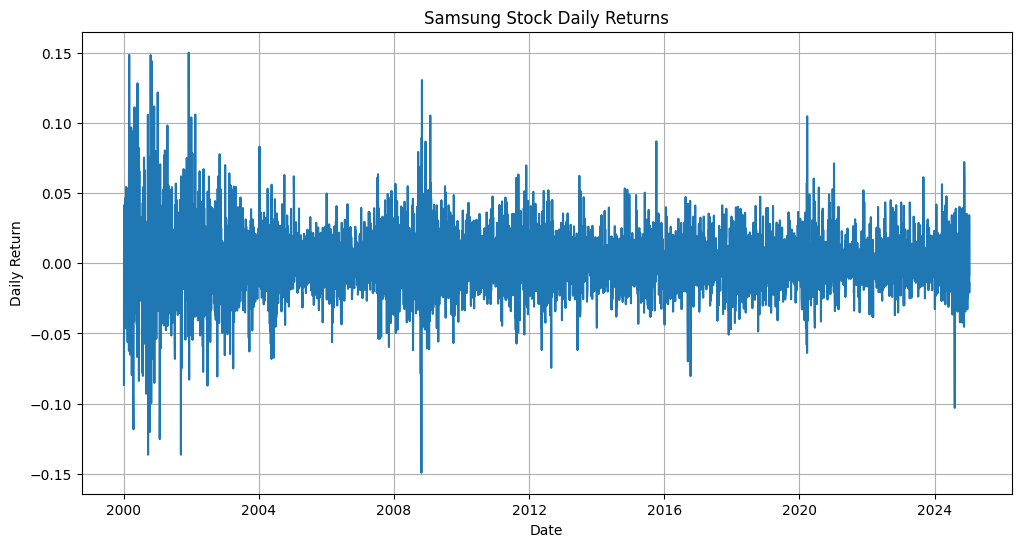

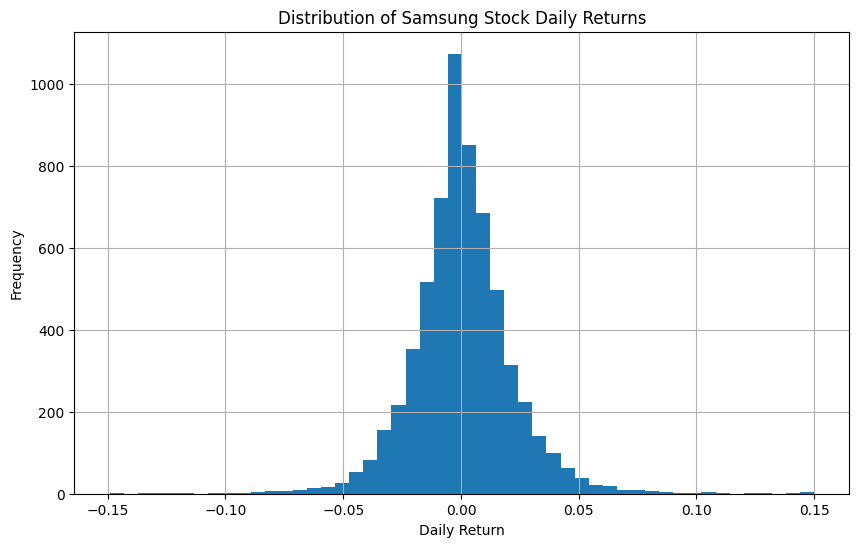

Text(0.5, 0, 'Date')

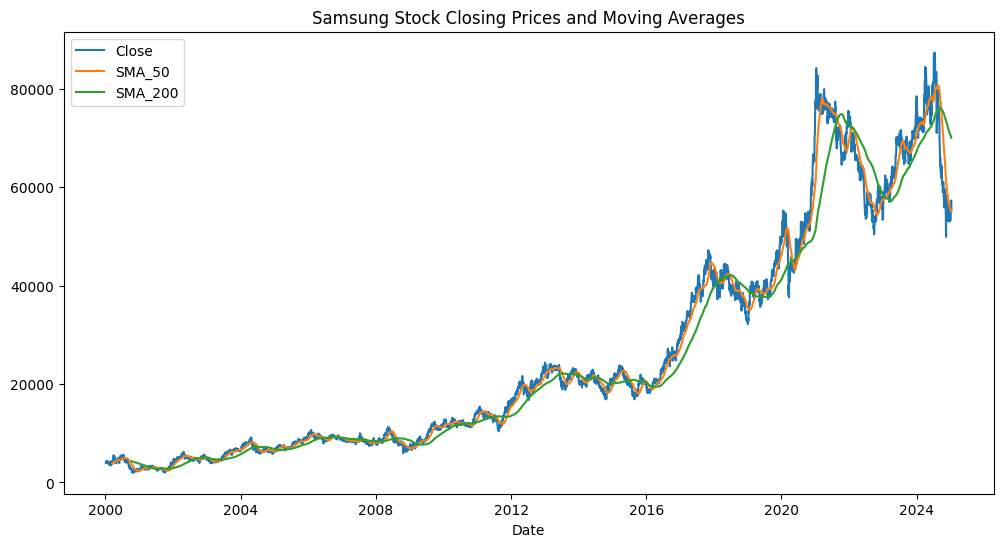

In [3]:
## Explorary Data Analysis

# Calculate daily returns
samsung_data['Daily_Return'] = samsung_data['Close'].pct_change()

# Drop the first row which will have a NaN value due to the pct_change() calculation
samsung_data = samsung_data.dropna()

# Display the first few rows to verify the calculation
print(samsung_data[['Close', 'Daily_Return']].head())

# Calculate descriptive statistics of the daily returns
print("\nDescriptive Statistics of Daily Returns:")
print(samsung_data['Daily_Return'].describe())


plt.figure(figsize=(12, 6))
plt.plot(samsung_data.index, samsung_data['Daily_Return'])
plt.title('Samsung Stock Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.grid(True)
plt.show()

# Plot the distribution of daily returns
plt.figure(figsize=(10, 6))
samsung_data['Daily_Return'].hist(bins=50)
plt.title('Distribution of Samsung Stock Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.show()

# Calculate the moving averages
samsung_data['SMA_50'] = samsung_data['Close'].rolling(window=50).mean()
samsung_data['SMA_200'] = samsung_data['Close'].rolling(window=200).mean()

# Plot the closing prices and moving averages
plt.figure(figsize=(12, 6))
plt.plot(samsung_data.index, samsung_data['Close'], label='Close')
plt.plot(samsung_data.index, samsung_data['SMA_50'], label='SMA_50')
plt.plot(samsung_data.index, samsung_data['SMA_200'], label='SMA_200')
plt.title('Samsung Stock Closing Prices and Moving Averages')
plt.legend(loc='upper left')
plt.xlabel('Date')

Before 2008, stock prices were relatively stable. Looking at the daily returns timeline we observe that in 2008 there was a significant drop in daily returns, which may be due to the Global Financial Crisis. After this, we have begun to see a steady increase in stock price which begins to really pick up in 2016 due to increased investent in the booming tech sector. Fast forward to 2020, the moving averages and daily returns have indicated Samsung's decling performance during the COVID-19 pandemic, which had significantly impacted global supply chains. From 2022-24, the stock prices started to recover, and the average daily returns increased because of Samsung's adaptability to the new market environment.

To enhance our understanding of the Samsung stocks, we will calculate the following technical indicators:
* **Moving averages** (50, 200): To capture short-term trends over the past 50 (10 weeks) and 200 days (40we weeks).i
* **Relative Strength Index (RSI)**: To measurelthe current strength or weakness of a market.
* **Bollinger Bands**: To measure the deviation of price from the moving average. 
* **On-Balance Volume (OBV)**: To measure the flow of money into and out of a security.
* **MACD**: To measure the momentum of a security.
* **Volatility analysis** - Wide daily range (high-low) indicates strong activity while narrow daily range indicates weak activity. 
* **Multiday pattern analysis**: These patterns are indicators of potential signals for uptrends or downtrends

**How we will use these indicators:**

**RSI values**  - If RSI is above 70, it indicates a strong selling signal, and if it is below 30, it indicates a strong buying signal. We confirm the trends when RSI remains above 40 and peaks near 70 for upward trends and RSI remains below 60 and bottoms near 30 for downward trends. Note that RSI can give false signals but is made more robust when combined with other measures, especially MACD. 

**Bollinger Bands** - Larger bands indicate higher volatility. Smaller bands indicate lower volatility. If prices touch the upper band, the stock might be overbought. If prices touch the lower band, the stock might be oversold. Prices exceeding either end of the band signal a strong trend. When prices hit the lower end of the band, this indicates a potential signal for buying and when prices hit the higher end of the band, this indicates a potential signal for selling. To detect potential breakout signals, we look for 'squeezes' i.e when bands contract tightly to indicate low volatility. Price volume may be used to detect direction of the breakout if possible. 

**OBV** - During an uptrend, increasng OBV can be used to confirm the trend's strength. Likewise for the downtrend. If OBV rises while the stock price falls or remains flat, this can indicate accumulation and a potential price increase.(Bullish) If OBV falls while the stock price rises or remains flat, this can indicate depreciation and a potential price decrease. (Bearish) Sudden spikes in OBV can indicate a potential breakout. OBV and RSI can detect divergences while OBV and Bolinger bands can validate breakouts. For histogram charts, the MACD can be used to detect divergences and identify potential buy and sell signals. Higher bars indicate increasing momentum in the direction of the trend and lower bars indicate decreasing momentum in the direction of the trend. It can also mean a possible trend change.

**MACD** - If MACD crosses over the signal line, this indicates a potential buy signal. If MACD crosses under the signal line, this indicates a potential sell signal. If the price is at a lower low and the MACD is at a higher low, this indicates a potential reversal upwards. If the price is at a higher high and the MACD is at a lower high, this indicates a potential reversal downwards. 

**Volatility Analysis** - If volatility exceeds the upper band, it indicates a strong upward trend. If volatility falls below the lower band, it indicates a strong downward trend. If volatility is at the upper band, it indicates a potential breakout positive. If volatility is at the lower band, it indicates a potential breakout negative.

**Multiday pattenrs** - If higher highs and higher lows continue to show consecutively, this indicates a potential uptrend. If lower lows and lower highs continue to show consecutively, this indicates a potential downtrend. These indcators will inform traders of future buying or selling signals.

**Limitations:**
**RSI** can give false signals but is made more robust when combined with other measures, especially MACD. **Boliinger bands** cannot predict directions of the breakouts. **OBV** assumes that all volume on an upward day is bought and on a downward day is sold. This does not reflect actuual market conditions. OBV is cumulative so errors can propagate over time. **MACD** uses moving average so it can give signals during a trend which may be false or lagging. 

These features will help us understand the behaviour of the stock over time and help us model future trends.

In [4]:
#RSI
def calculate_rsi(close, window=14):
    delta = close.diff().dropna()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    ema_up = up.ewm(com=window-1, adjust=False).mean()
    ema_down = down.ewm(com=window-1, adjust=False).mean()
    rs = ema_up / ema_down
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Bollinger Bands
def calculate_bollinger_bands(close, window=20, std_dev=2):
    rolling_mean = close.rolling(window=window).mean()
    rolling_std_dev = close.rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std_dev * std_dev)
    lower_band = rolling_mean - (rolling_std_dev * std_dev)
    return rolling_mean, upper_band, lower_band
#OBV
def calculate_obv(close, volume):
    obv = pd.Series(0, index=close.index)
    obv.iloc[0] = volume[0]
    for i in range(1, len(close)):
        if close.iloc[i] > close.iloc[i-1]:
            obv.iloc[i] = obv.iloc[i-1] + volume[i]
        elif close.iloc[i] < close.iloc[i-1]:
            obv.iloc[i] = obv.iloc[i-1] - volume[i]
        else:
            obv.iloc[i] = obv.iloc[i-1]
    return obv 
# MACD
def calculate_macd(close, short_window=12, long_window=26, signal_window=9):
    macd = close.ewm(span=short_window, adjust=False).mean() - close.ewm(span=long_window, adjust=False).mean()
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    macd_histogram = macd - signal
    return macd, signal, macd_histogram


In [5]:
rsi=calculate_rsi(samsung_data['Close'],20)
bbmb,bbub,bblb=calculate_bollinger_bands(samsung_data['Close'],20,2)
obv=calculate_obv(samsung_data['Close'],samsung_data['Volume'])
macd, macd_signal, macd_histogram=calculate_macd(samsung_data['Close'],10,20,5)

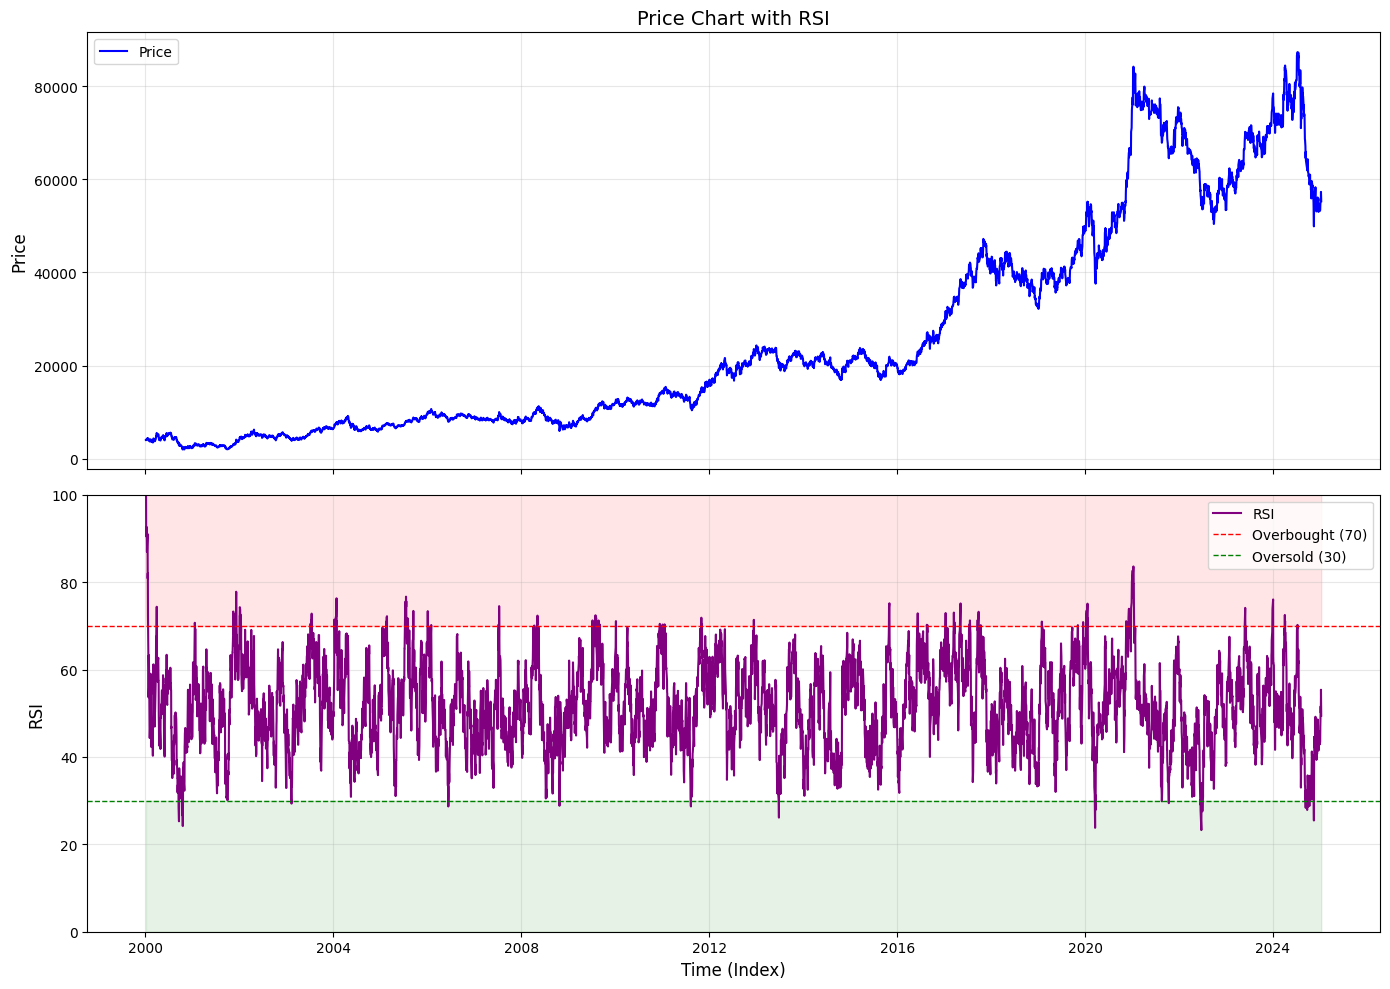

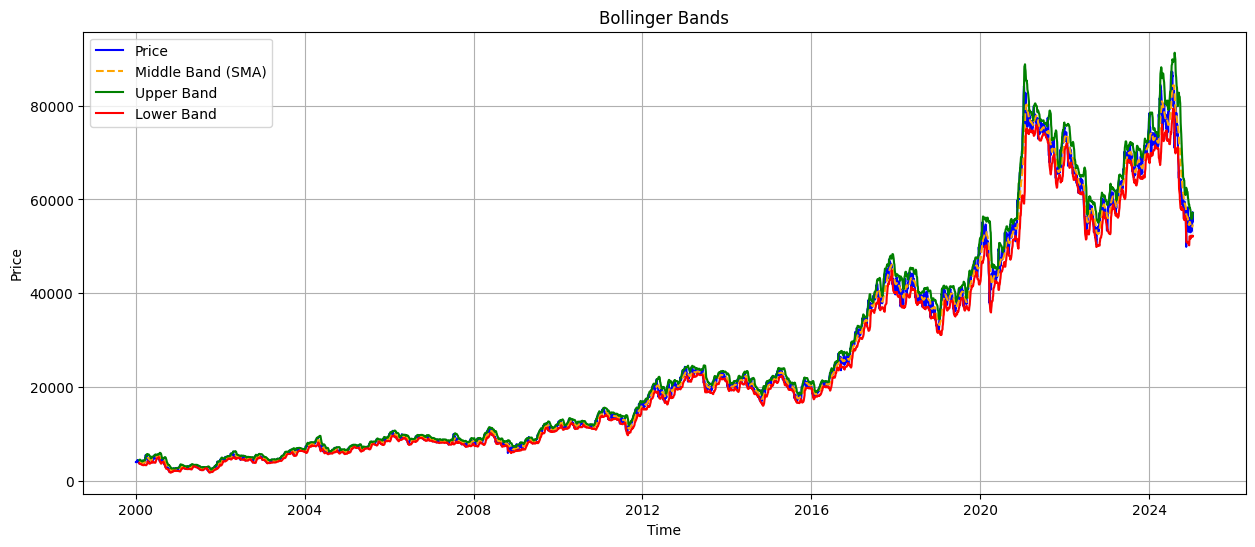

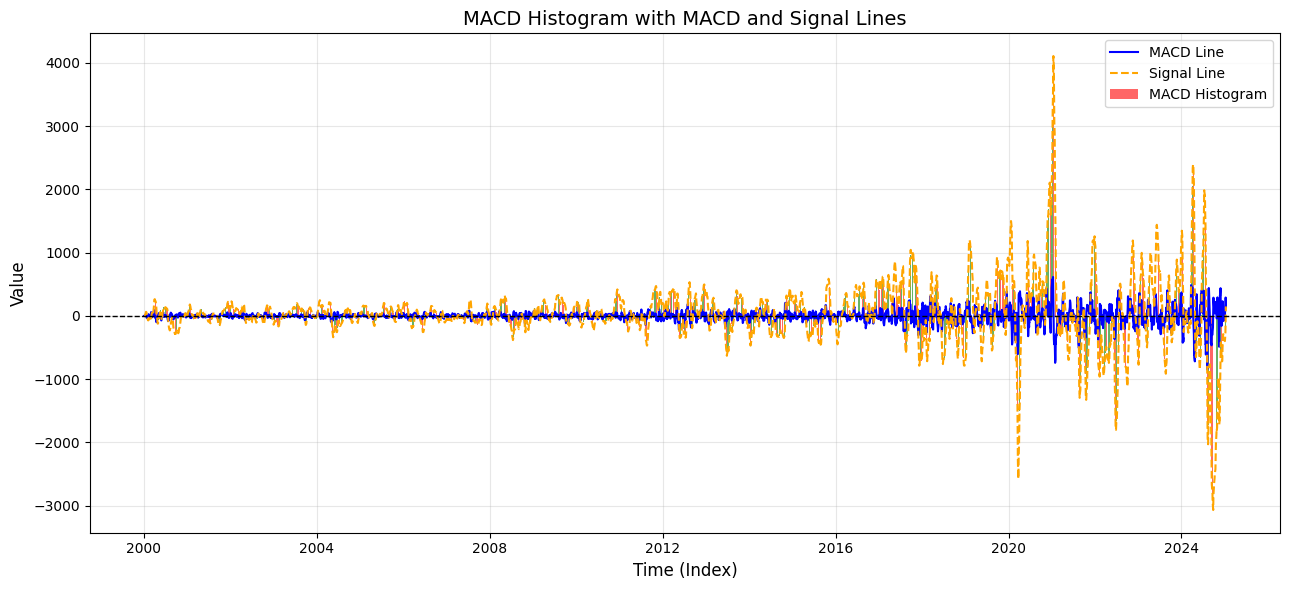

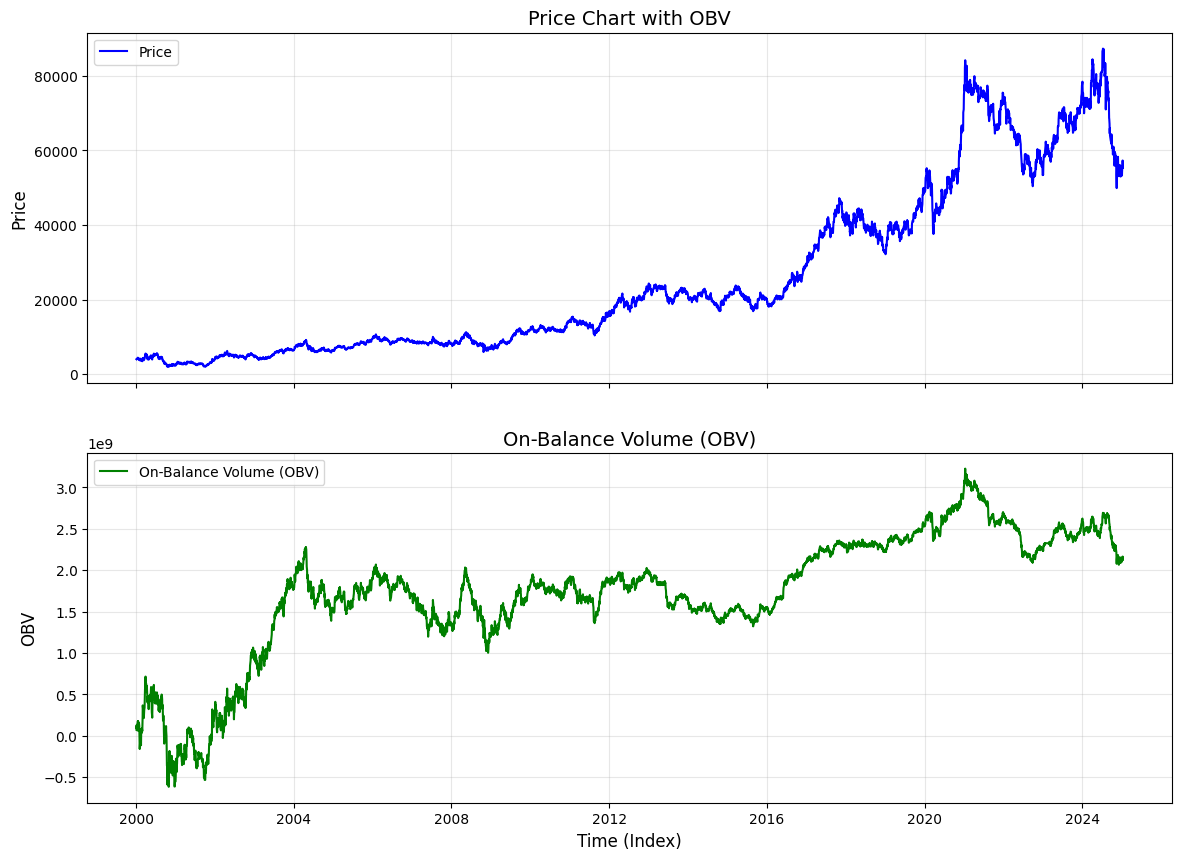

Text(0, 0.5, 'Percentage')

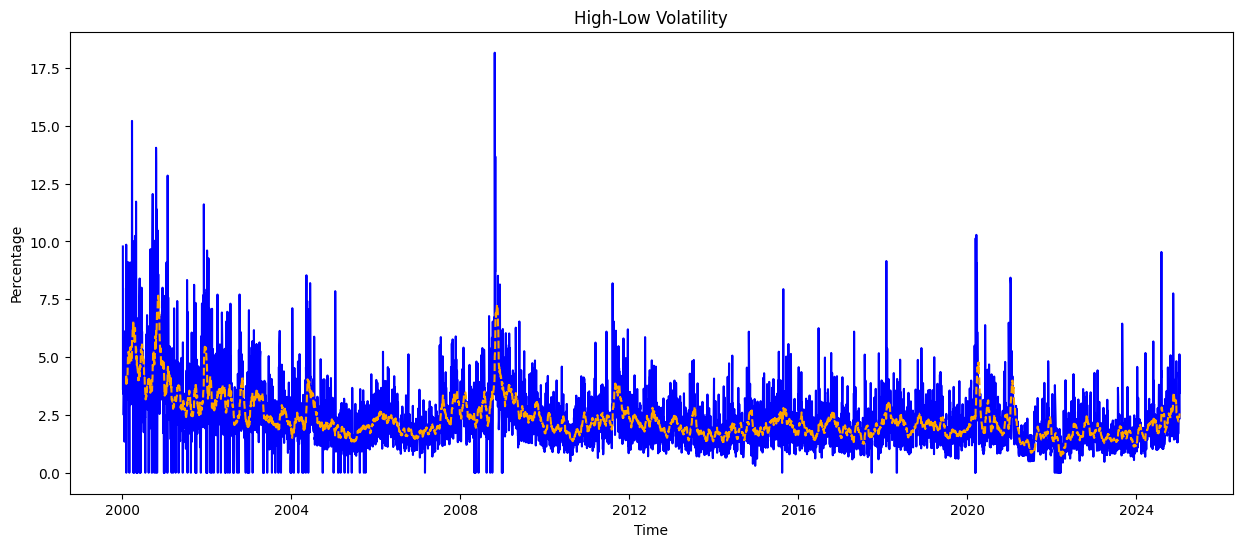

In [6]:
# Plot Price and RSI
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Price chart
ax1.plot(samsung_data['Close'], label="Price", color="blue", linewidth=1.5)
ax1.set_title("Price Chart with RSI", fontsize=14)
ax1.set_ylabel("Price", fontsize=12)
ax1.legend()
ax1.grid(alpha=0.3)

# RSI chart
ax2.plot(rsi, label="RSI", color="purple", linewidth=1.5)
ax2.axhline(70, color="red", linestyle="--", linewidth=1, label="Overbought (70)")
ax2.axhline(30, color="green", linestyle="--", linewidth=1, label="Oversold (30)")
ax2.fill_between(samsung_data.index, 70, 100, color="red", alpha=0.1)
ax2.fill_between(samsung_data.index, 0, 30, color="green", alpha=0.1)
ax2.set_ylim(0, 100)
ax2.set_ylabel("RSI", fontsize=12)
ax2.set_xlabel("Time (Index)", fontsize=12)
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Plot Bolinger Bands
plt.figure(figsize=(15, 6))
plt.plot(samsung_data["Close"], label="Price", color="blue")
plt.plot(bbmb, label="Middle Band (SMA)", color="orange", linestyle="--")
plt.plot(bbub, label="Upper Band", color="green")
plt.plot(bblb, label="Lower Band", color="red")
plt.fill_between(samsung_data.index, bbub, bblb, color="gray", alpha=0.1)
plt.legend()
plt.title("Bollinger Bands")
plt.xlabel("Time")
plt.ylabel("Price")
plt.grid()
plt.show()

# Plot MACD histogram
plt.figure(figsize=(13, 6))

# Plot MACD Line and Signal Line
plt.plot(macd_histogram, label="MACD Line", color="blue", linewidth=1.5)
plt.plot(macd_signal, label="Signal Line", color="orange", linestyle="--", linewidth=1.5)

# Plot Histogram
plt.bar(samsung_data.index,macd_signal, label="MACD Histogram", 
        color=np.where(macd_histogram > 0, 'green', 'red'), alpha=0.6)

# Add zero line
plt.axhline(0, color="black", linestyle="--", linewidth=1)

# Chart customization
plt.title("MACD Histogram with MACD and Signal Lines", fontsize=14)
plt.xlabel("Time (Index)", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

# Show the plot
plt.show()

#Plot obv
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Price Chart
ax1.plot(samsung_data['Close'], label="Price", color="blue", linewidth=1.5)
ax1.set_title("Price Chart with OBV", fontsize=14)
ax1.set_ylabel("Price", fontsize=12)
ax1.legend()
ax1.grid(alpha=0.3)

# OBV Chart
ax2.plot(obv, label="On-Balance Volume (OBV)", color="green", linewidth=1.5)
ax2.set_title("On-Balance Volume (OBV)", fontsize=14)
ax2.set_ylabel("OBV", fontsize=12)
ax2.set_xlabel("Time (Index)", fontsize=12)
ax2.legend()
ax2.grid(alpha=0.3)
plt.show()

#Daily volatility chart with moving average of volatility
high_low_volatility = (samsung_data['High'] - samsung_data['Low']) / samsung_data['Low'] * 100
plt.figure(figsize=(15, 6))
plt.plot(high_low_volatility, label="High-Low Volatility", color="blue")
plt.plot(high_low_volatility.rolling(window=20).mean(), label="Moving Average (20 days)", color="orange", linestyle="--")
plt.title("High-Low Volatility")
plt.xlabel("Time")
plt.ylabel("Percentage")




These visuals provide metrics relevant to the past trends but to predict future trends in the metrics, machine learning algorithms or statistical models would be more suitable. The combination of these indicators, such as RSI, Bollinger Bands, MACD, and On-Balance Volume (OBV), can help investors make informed decisions. We will predict each indicator by predicting the actual price to help provide advice to traders. We will use supervised learning techniques used predominantly on time series data, such as time series regression, ARIMA, or LSTM (Long Short-Term Memory) networks. 

## Preprocessing and model selection
We want to predict the differences between the daily high and low, closing prices and volume to predict the future values of the indicators discussed earlier. First, let's look at the closing price. To simplify the problem we will take our training and testing data to be from before the pandemic. Furthermore, we will exclude the period before the global financial crisis to account for the uncertainty in the stock market. In a separate case, we can still include data from the pandemic period to now.

In [7]:
training_data = samsung_data.loc['2008-12-05':'2020-03-01']
training_data

,Open,High,Low,Close,Volume,Daily_Return,SMA_50,SMA_200
Date,,,,,,,,
2008-12-05 00:00:00+09:00,6283.717862,6453.548075,6283.717862,6305.869629,29513550,-0.008130,7222.215010,8667.223494
2008-12-08 00:00:00+09:00,6416.628834,6867.048119,6350.173529,6852.280273,40352200,0.086651,7198.586436,8660.166028
2008-12-09 00:00:00+09:00,6881.815474,6933.502930,6689.833498,6933.502930,29640550,0.011853,7178.059072,8654.326282
2008-12-10 00:00:00+09:00,6926.119831,7103.333984,6881.816293,7103.333984,37277700,0.024494,7162.700527,8649.114338
2008-12-11 00:00:00+09:00,7118.100941,7140.252708,6800.592289,7125.484863,51925650,0.003118,7149.261719,8643.275312
...,...,...,...,...,...,...,...,...
2020-02-24 00:00:00+09:00,50771.406883,51390.570381,50240.695312,50240.695312,25627537,-0.040541,51277.389687,43546.868750
2020-02-25 00:00:00+09:00,49709.985144,51302.119900,49709.985144,51213.667969,23885408,0.019366,51396.429688,43606.836758
2020-02-26 00:00:00+09:00,49533.080199,50417.599488,49533.080199,49975.339844,25483102,-0.024180,51483.672109,43662.561191


In [ ]:
#difference the closing prices to make the data stationary
training_data['Close_diff'] = training_data['Close'].diff()
training_data.dropna(inplace=True)

We perform ACF and PACF to determine the appropriate number of lags for our models and whether to treat the data as seasonal.

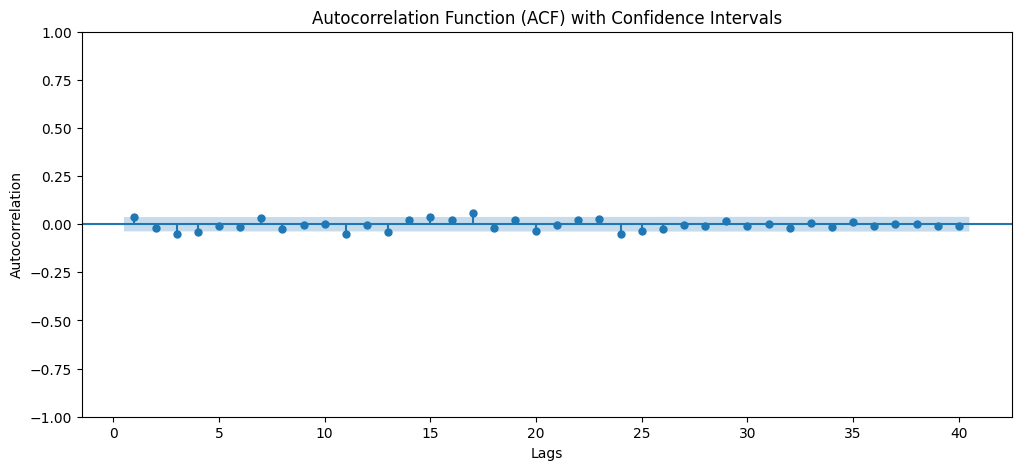

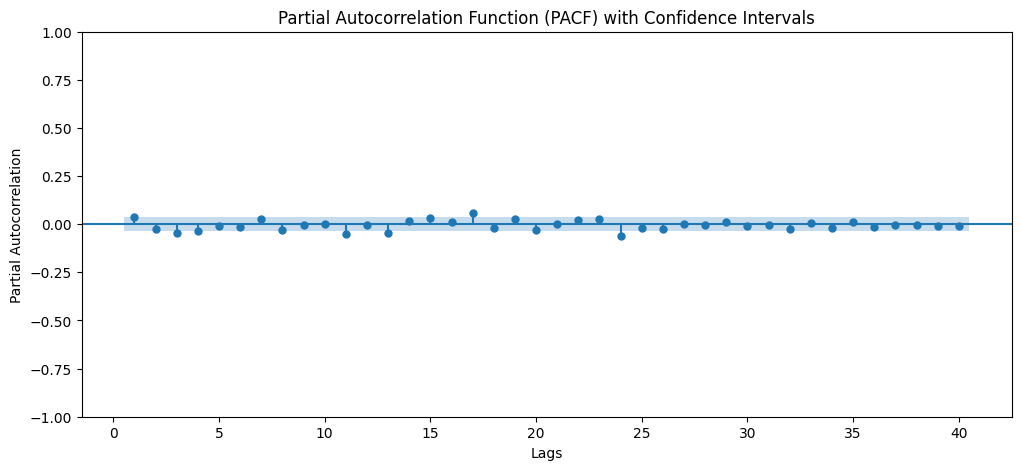

In [9]:
#perform ACF
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
# Create the ACF plot with confidence intervals
fig, ax = plt.subplots(figsize=(12, 5))
plot_acf(training_data['Close_diff'], ax=ax, lags=range(1,41))
plt.title('Autocorrelation Function (ACF) with Confidence Intervals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()
#plot pacf with confidence intervals
fig, ax = plt.subplots(figsize=(12, 5))
plot_pacf(training_data['Close_diff'], ax=ax, lags=range(1,41))
plt.title('Partial Autocorrelation Function (PACF) with Confidence Intervals')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.show()

Looking at both the ACF and PACF plots, we see that there are significant lags at 1, 3, 11, 13, 17, 24. From the plot, we can see that the data is not really seasonal because there are no regular patterns in occurences of spikes above the confidence interval area. To proceed, we will use the ARIMA model with no seasonal parameters and consider only the significant lags for cross-validation, which is a popular time series forecasting model. The ARIMA model assumes that the time series is stationary and autocorrelated. 

In [ ]:
#split the data into training, validation, and test sets for linear regression
#add lagged values to the training data
training_data['lag_1'] = training_data['Close'].shift(1)
training_data['lag_3'] = training_data['Close'].shift(3)
training_data['lag_11'] = training_data['Close'].shift(11)
training_data['lag_13'] = training_data['Close'].shift(13)
training_data['lag_17'] = training_data['Close'].shift(17)
training_data['lag_24'] = training_data['Close'].shift(24)
#split the data into training, validation, and test sets
train_size = int(len(training_data) * 0.8)
validation_size = int(len(training_data) * 0.1)
test_size = len(training_data) - train_size - validation_size
training_data.dropna(inplace=True)
#we lose 12 days of trading data due to shifting

In [11]:
from math import floor
X=training_data[['lag_1','lag_3','lag_11','lag_13','lag_17','lag_24']]
y=training_data['Close_diff']#predict on stationary data
rolling_rmse = []
train_size=floor(0.7*len(training_data))
test_size=floor(0.2*len(training_data))
# Loop through the time series with a rolling window
for start in range(len(training_data) - train_size - test_size + 1):
    end_train = start + train_size
    start_test = end_train
    end_test = start_test + test_size

    # Split into training and testing sets
    X_train = np.array(range(start, end_train)).reshape(-1, 1)
    X_val = np.array(range(start_test, end_test)).reshape(-1, 1)
    y_train = training_data.iloc[start:end_train].values
    y_val = training_data.iloc[start_test:end_test].values

    # Initialize and train the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_val)

    # Evaluate performance (RMSE)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rolling_rmse.append(rmse)

# Average RMSE across all windows
average_rolling_rmse = np.mean(rolling_rmse)
print(f"Average Rolling Window RMSE: {average_rolling_rmse}")

Average Rolling Window RMSE: 1697988.013992496


We note that before testing, already during rolling window cross validation, multiple linear regression is an inappropriate model for predicting the daily closing prices of Samsung Electronics, as the data is non-linear. Let's proceed with ARIMA.